In [1]:
include("../src/Hydro.jl");

In [2]:
using .Hydro
using CSV
using DataFrames
using Printf: @sprintf

# Load some data

In [3]:
# load a test dataset from a CSV file into a dataframe
df = CSV.read("../test/data/test_2_data.csv", header=1, missingstrings=["-9999"]);

In [4]:
size(df)

(12417, 5)

In [5]:
len = @sprintf("%.1f", size(df)[1] / 365)
println("Period of record is $len years")

Period of record is 34.0 years


In [6]:
names(df)

5-element Array{Symbol,1}:
 :date            
 :obs_rain        
 :obs_pet         
 :obs_runoff      
 :obs_runoff_sim_0

In [7]:
# rename the columns
names!(df, Symbol.(["date", "obs_rain", "obs_pet", "obs_runoff", "test_sim_runoff"]));

In [8]:
# Create a dictionary of data from the dataframe - standard data structure through Hydro
data = Dict()
data["rain"] = df[:obs_rain]
data["pet"] = df[:obs_pet]
data["runoff_obs"] = df[:obs_runoff]
data["runoff_sim_test"] = df[:test_sim_runoff];

# Calibrate GR4J parameters

- GR4J model with NSE objective function (minimised so -ve)
- Differential evolution optimiser with adaptive weights over a limited radius
- Take best parameter set after 5 minutes
- Display best sample every 15 seconds

Available methods: https://github.com/robertfeldt/BlackBoxOptim.jl#existing-optimizers

In [30]:
# build up dictionary of model functions needed for calibration
functions = Dict()
functions["run_model_time_step"] = gr4j_run_step
functions["init_state"] = gr4j_init_state
functions["params_from_array"] = gr4j_params_from_array
functions["objective_function"] = (obs, sim) -> -1 * nse(obs, sim)
functions["params_inverse_transform"] = gr4j_params_trans_inv
functions["params_range_transform"] = gr4j_params_range_trans
functions["params_range_to_tuples"] = gr4j_params_range_to_tuples

gr4j_params_range_to_tuples (generic function with 1 method)

In [31]:
# build up dictionary of optimiser options needed for calibration
opt_options = Dict()
opt_options["max_iterations"] = false
opt_options["max_time"] = 5 * 60
opt_options["trace_interval"] = 15
opt_options["method"] = :adaptive_de_rand_1_bin_radiuslimited  # 0.83
#opt_options["method"] = :adaptive_de_rand_1_bin # 0.80
#opt_options["method"] = :de_rand_1_bin_radiuslimited # 0.83
#opt_options["method"] = :de_rand_1_bin # 0.80
#opt_options["method"] = :generating_set_search # 0.83

:adaptive_de_rand_1_bin_radiuslimited

In [32]:
opt_pars, opt_nse = calibrate(functions, opt_options, data, gr4j_params_range())
opt_nse *= -1

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
15.31 secs, 67 evals, 39 steps, improv/step: 0.487 (last = 0.4872), fitness=-0.784010414
30.63 secs, 133 evals, 83 steps, improv/step: 0.470 (last = 0.4545), fitness=-0.784010414
45.74 secs, 204 evals, 138 steps, improv/step: 0.442 (last = 0.4000), fitness=-0.784010414
61.12 secs, 277 evals, 199 steps, improv/step: 0.412 (last = 0.3443), fitness=-0.784010414
76.22 secs, 347 evals, 262 steps, improv/step: 0.389 (last = 0.3175), fitness=-0.784010414
91.38 secs, 417 evals, 329 steps, improv/step: 0.374 (last = 0.3134), fitness=-0.784010414
106.40 secs, 486 evals, 393 steps, improv/step: 0.359 (last = 0.2813), fitness=-0.784010414
121.57 secs, 556 evals, 461 steps, improv/step: 0.349 (last = 0.2941), fitness=-0.784010414
136.7

0.8202490116039289

In [33]:
opt_pars

Dict{String,Float64} with 4 entries:
  "x1" => 19.8328
  "x4" => 1.54803
  "x2" => -1.1354
  "x3" => 239.038

In [34]:
# test parameters were
gr4j_params_from_array(CSV.read("../test/data/test_2_params.csv", delim=":", header=0)[2])

Dict{String,Float64} with 4 entries:
  "x1" => 55.0616
  "x4" => 1.49495
  "x2" => -0.039867
  "x3" => 249.783

# Simulate using these calibrated parameters

In [35]:
init_state = gr4j_init_state(opt_pars)

Dict{String,Any} with 6 entries:
  "uh2"              => [0.0, 0.0, 0.0, 0.0]
  "production_store" => 0
  "uh2_ordinates"    => [0.167696, 0.621389, 0.210435, 0.000479603]
  "routing_store"    => 0
  "uh1"              => [0.0, 0.0]
  "uh1_ordinates"    => [0.335391, 0.664609]

In [36]:
data = simulate(gr4j_run_step, data, opt_pars, init_state);

In [37]:
keys(data)

Base.KeySet for a Dict{Any,Any} with 6 entries. Keys:
  "runoff_sim"
  "pet"
  "rain"
  "runoff_obs"
  "runoff_sim_test"
  "runoff_sim_gr4j"

In [38]:
data["runoff_sim_gr4j"] = data["runoff_sim"];

In [39]:
keys(data)

Base.KeySet for a Dict{Any,Any} with 6 entries. Keys:
  "runoff_sim"
  "pet"
  "rain"
  "runoff_obs"
  "runoff_sim_test"
  "runoff_sim_gr4j"

# Do same for simple OSTP educational model
One store and two parameters

Just search for 1 minute, searching for longer wont find a magic parameter set that makes this a good model!

In [46]:
# build up dictionary of model functions needed for calibration
functions = Dict()
functions["run_model_time_step"] = ostp_run_step
functions["init_state"] = ostp_init_state
functions["params_from_array"] = ostp_params_from_array
functions["objective_function"] = (obs, sim) -> -1 * nse(obs, sim)
functions["params_inverse_transform"] = ostp_params_trans_inv
functions["params_range_transform"] = ostp_params_range_trans
functions["params_range_to_tuples"] = ostp_params_range_to_tuples

# build up dictionary of optimiser options needed for calibration
opt_options = Dict()
opt_options["max_iterations"] = false
opt_options["max_time"] = 1 * 60
opt_options["trace_interval"] = 15
opt_options["method"] = :adaptive_de_rand_1_bin_radiuslimited  # 0.83
#opt_options["method"] = :adaptive_de_rand_1_bin # 0.80
#opt_options["method"] = :de_rand_1_bin_radiuslimited # 0.83
#opt_options["method"] = :de_rand_1_bin # 0.80
#opt_options["method"] = :generating_set_search # 0.83

opt_pars, opt_nse = calibrate(functions, opt_options, data, ostp_params_range())
opt_nse *= -1

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
15.01 secs, 1827 evals, 1738 steps, improv/step: 0.368 (last = 0.3682), fitness=-0.286316063
30.02 secs, 3611 evals, 3525 steps, improv/step: 0.310 (last = 0.2535), fitness=-0.286334992
45.02 secs, 5361 evals, 5275 steps, improv/step: 0.296 (last = 0.2669), fitness=-0.286334992

Optimization stopped after 7094 steps and 60.00682592391968 seconds
Termination reason: Max time (60.0 s) reached
Steps per second = 118.21988400110025
Function evals per second = 119.65305428924441
Improvements/step = Inf
Total function evaluations = 7180


Best candidate found: [17.7228, 20.4871]

Fitness: -0.286334992



0.2863349917208353

In [47]:
opt_pars

Dict{String,Float64} with 2 entries:
  "loss"     => 20.4871
  "capacity" => 17.7228

In [48]:
init_state = ostp_init_state(opt_pars)

8.861390980715049

In [49]:
data = simulate(ostp_run_step, data, opt_pars, init_state);

# Plot a hydrograph of this simulation with test simulation

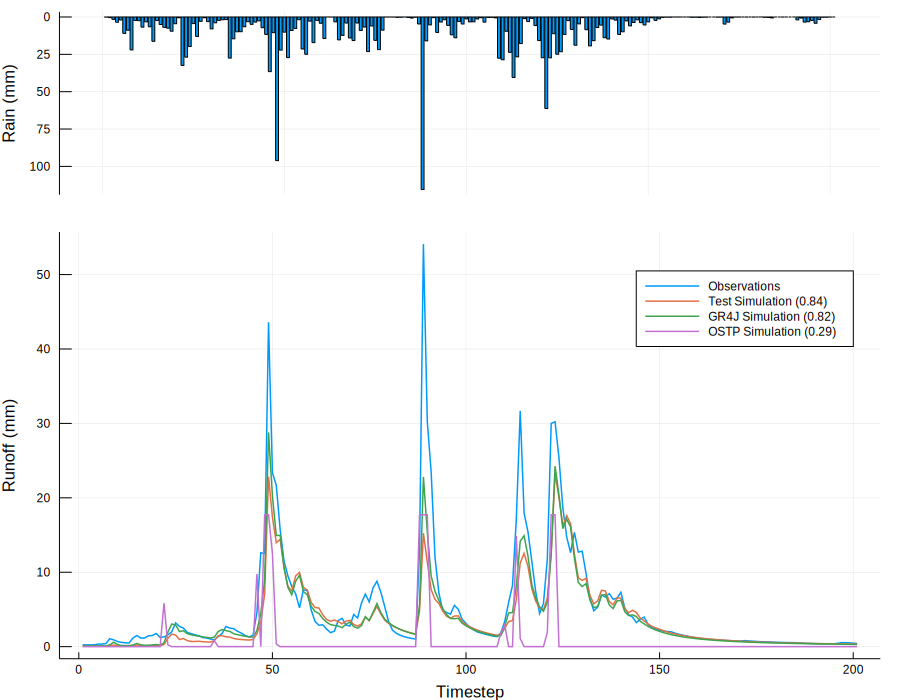

In [51]:
s, e = 12000, 12200

obs = data["runoff_obs"][s:e]
test = data["runoff_sim_test"][s:e]
gr4j = data["runoff_sim_gr4j"][s:e]
ostp = data["runoff_sim"][s:e]
rain = data["rain"][s:e]

nse_test = @sprintf("%.2f", nse(data["runoff_obs"], data["runoff_sim_test"]))
nse_gr4j = @sprintf("%.2f", nse(data["runoff_obs"], data["runoff_sim_gr4j"]))
nse_ostp = @sprintf("%.2f", nse(data["runoff_obs"], data["runoff_sim"]))

hydrograph(rain, [obs, test, gr4j, ostp], 
    ["Observations", "Test Simulation ($nse_test)", "GR4J Simulation ($nse_gr4j)", "OSTP Simulation ($nse_ostp)"])